In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

operating_system = 'mac'

if operating_system == 'win':
    os.chdir('C:/Users/fabau/OneDrive/Documents/GitHub/master-project-cleaned/')
elif operating_system == 'curnagl':
    os.chdir('/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/cleaner_version/')
else:
    os.chdir('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/')

util_perso = os.path.abspath('util/gev')
sys.path.append(util_perso)
util_perso = os.path.abspath('util/processing')
sys.path.append(util_perso)

import time_series
from data_processing import depickle

/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.3.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


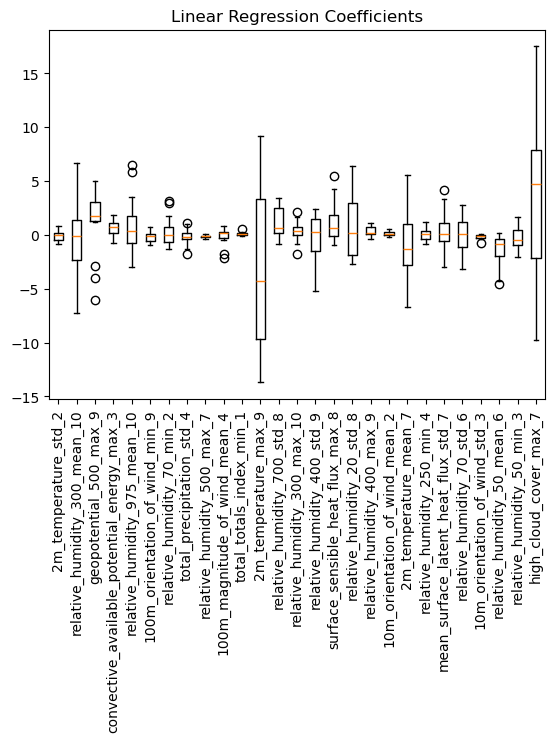

In [3]:
model = depickle('analysis_loadings_selected/z_gust/best_linear_cdf_model.pkl')
features = pd.DataFrame(depickle('analysis_loadings_selected/z_gust/best_linear_cdf_feature.pkl'),
                        columns = ['var_name', 'PC'])

# get the coefficients
coefficients = model.coef_
# Print feature names alongside coefficients
feature_names = features['var_name']+'_'+features['PC'].astype(str)


plt.boxplot(coefficients)
plt.xticks(range(1, 27 + 1), feature_names, rotation=90)

if coefficients.shape == 1:
    for feature_name, coef in zip(feature_names, coefficients):
        print(f"{feature_name}: {coef:.3f}")

    # Sort by absolute value
    sorted_indices = np.argsort(np.abs(coefficients))[::-1]  # descending order
    sorted_coefs = coefficients[sorted_indices]
    sorted_names = feature_names[sorted_indices]

    plt.figure(figsize=(10, 10))
    bars = plt.bar(sorted_names, sorted_coefs)

    # You can also color-code bars by sign if you want:
    for bar, coef in zip(bars, sorted_coefs):
        bar.set_color('g' if coef >= 0 else 'r')
    #plt.bar(sorted_names, sorted_coefs)
    plt.xticks(rotation=90)
    plt.ylabel('Coefficient value')
plt.title(f'Linear Regression Coefficients')
#plt.tight_layout()
plt.show()